### Importing the theoretical $D_{l}$ obtained with CAMB (Lewis et. al. 2006)

In [100]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from input_camb import *

In [101]:
Dl

array([   0.        ,    0.        , 1028.01454306, ...,   66.35034063,
         66.2225099 ,   66.09623955])

In [102]:
ls=np.arange((Dl.shape[0]))

In [103]:
lmax = 2500
nside=2048
mapa_cl = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(1/60), new= True)

[healpy] Sigma is 0.424661 arcmin (0.000124 rad) 
[healpy] -> fwhm is 1.000000 arcmin


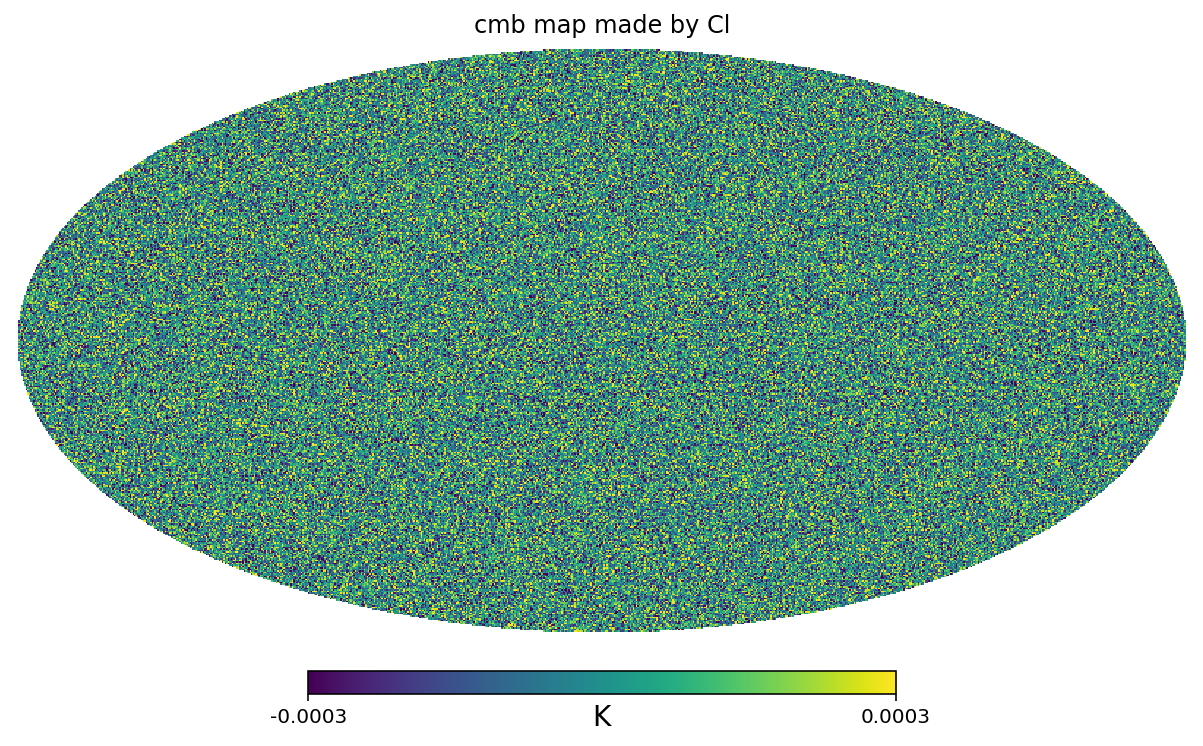

In [104]:
hp.mollview(mapa_cl*(1e-8), title = 'cmb map made by Cl', unit = 'K', min=-3e-4, max=3e-4)

In [105]:
cmb_map=np.save('mapa_cl_1', mapa_cl)

In [106]:
# ells
Cls=hp.anafast(mapa_cl, lmax=2551)
el=np.arange(len(Cls))


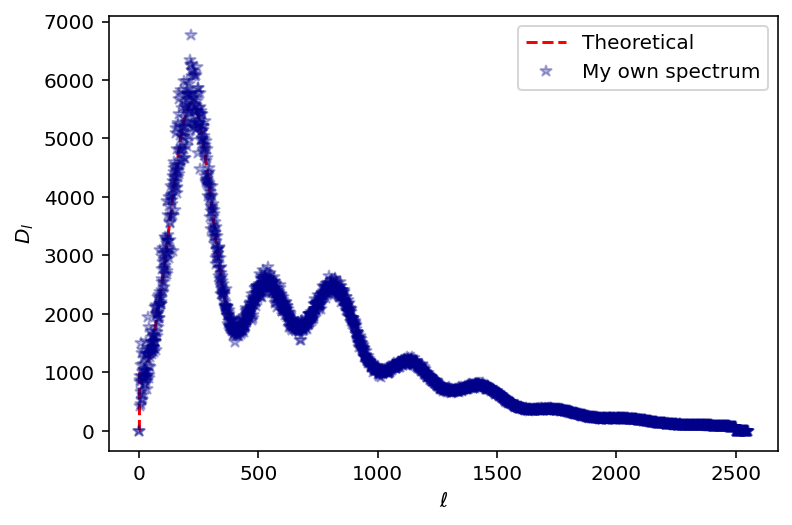

In [112]:
plt.plot(ls,Dl,'--',  color= 'r', label='Theoretical')
plt.plot(el,Cls, '*', alpha = 0.3, color = 'darkblue', label='My own spectrum')
plt.xlabel('$\ell$')
plt.ylabel(r'$D_l$')
plt.legend()

In [86]:

np.savetxt('Cls',Cls)

Experimental errors

In [87]:
from IPython.display import display, Math
display(Math(r'\sigma(C_{\ell})= \sqrt{\frac{2}{(2l+1)f_{sky}}} \cdot C_{\ell}'))

<IPython.core.display.Math object>

In this subsection, I am going to compute the errors of pseudo \(C_\ell\). To compute the errors for the pseudo-power spectrum, you can estimate them using a simple approximation. One of the most straightforward methods is to assume that the errors are dominated by cosmic variance and noise, which gives:

$$\sigma(C_{\ell})= \sqrt{\frac{2}{(2l+1)f_{sky}} \cdot C_{\ell}}$$

Where $C_{\ell}$ are my pseudo power spectrum,
$f_{sky}=1$ is fraction of our sky for analysis.

In [88]:
Cl_err = np.sqrt(2 / (2*el + 1))*Cls

In [89]:
sigma=np.savetxt('sigma',Cl_err)

## MCMC with Cobaya (Lewis  & Torrado 2021)

In [90]:
from cobaya.likelihood import Likelihood

I establish the Likelihood 

In [93]:
class myLikelihood(Likelihood):
    def initialize(self):
        """
         Prepare any computation, importing any necessary code, files, etc.

         e.g. here we load some data file, with default cl_file 
        """
        self.data = np.loadtxt(Cls)
        self.errors = np.loadtxt(sigma)
     
    def get_requirements(self):
        """
         return dictionary specifying quantities calculated by a theory code are needed

         e.g. here we need C_L^{tt} to lmax=2552
        """
        return {'Cl': {'tt': 2552}}
    
    def logp(self, **params_values):
        # Calculate the likelihood using self.data and the theoretical Cls
        Cl_theory = self.provider.get_Cl(ell_factor=True)
        # Compute the likelihood
        return -0.5 * np.sum((self.data - Cl_theory['tt'])**2 / self.errors**2)
        

Testing the likelihood

In [97]:
from cobaya.run import run

config = {
    "likelihood": {"planck_2018_lowl.TT": None},
    "theory": {
        "camb": {
            "extra_args": {
                "lens_potential_accuracy": 0,  # Desactiva la lente gravitacional si no es necesaria
                "halofit_version": "mead"  # Configuración opcional de Halofit
            },
            "lmax": 2500  # Define el lmax para los cálculos de Cl
        }
    },
    "params": {
        "H0": {
            "prior": {"min": 60, "max": 80},  # Prior para H0
            "ref": {"dist": "norm", "loc": 67.5, "scale": 1.0},
            "latex": r"H_0"
        },
        "omega_b": {
            "prior": {"min": 0.02, "max": 0.025},  # Prior para omega_b (ombh2)
            "ref": {"dist": "norm", "loc": 0.0221, "scale": 0.0001},
            "latex": r"\omega_b"
        },
        "omega_cdm": {
            "prior": {"min": 0.1, "max": 0.15},  # Prior para omega_cdm (omch2)
            "ref": {"dist": "norm", "loc": 0.121, "scale": 0.002},
            "latex": r"\omega_\mathrm{cdm}"
        },
        "tau_reio": {
            "prior": {"min": 0.04, "max": 0.1},  # Prior para la reionización (tau)
            "ref": {"dist": "norm", "loc": 0.06, "scale": 0.01},
            "latex": r"\tau_\mathrm{reio}"
        },
        "As": {
            "prior": {"min": 1e-9, "max": 3e-9},  # Prior para As (amplitud escalar)
            "ref": {"dist": "norm", "loc": 2.09e-9, "scale": 0.1e-9},
            "latex": r"A_s"
        },
        "ns": {
            "prior": {"min": 0.9, "max": 1.1},  # Prior para ns (índice espectral)
            "ref": {"dist": "norm", "loc": 0.963, "scale": 0.01},
            "latex": r"n_s"
        },
        "mnu": {
            "prior": {"min": 0, "max": 0.2},  # Prior para la masa de neutrinos
            "ref": 0.06,
            "latex": r"m_\nu"
        }
    },
    "sampler": {
        "mcmc": {
            "max_tries": 1000,
            
        }
    },
    "output": "cmb_folder",
    
}

info = run(config)


[output] Output to be read-from/written-into folder '.', with prefix 'cmb_folder'
[input] *ERROR* theory 'camb' does not recognize some options: 'lmax'. Check the documentation for 'theory'.


LoggedError: theory 'camb' does not recognize some options: 'lmax'. Check the documentation for 'theory'.